In [13]:
%matplotlib inline
import os, sys,math 
import numpy as np
import nibabel as nb 
from numpy import mean, std
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, ttest_ind, mannwhitneyu, wilcoxon, spearmanr,pearsonr, fisher_exact,kstest
from scipy.stats import ks_2samp, kstest, anderson, anderson_ksamp, levene
from statsmodels.sandbox.stats.multicomp import fdrcorrection0
from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.formula.api as smf#
import scipy.stats as ss 
from outliers import smirnov_grubbs as grubbs
from matplotlib.colors import ListedColormap
pd.options.display.max_columns = 999
sns.set_style('white')

workspace_dir  = '/Users/kanaan/Google Drive/TS-EUROTRAIN/RESULTS_QSMv3/dataframes'
#workspace_dir  = '/scr/malta3/workspace/project_iron/phenotypic'
pheno_dir      = os.path.join(workspace_dir, 'phenotypic')
clinical_dir   = os.path.join(workspace_dir, 'DF_clinical')
save_fig_dir   = '/Users/kanaan/Google Drive/TS-EUROTRAIN/Papers/2016_QSM_paper/Figures_python_v4'

dpi = 300

In [14]:
def detect_outlier_subjects(df,measure,m=2):
    upper = np.mean(df[measure]) + m * np.std(df[measure])
    lower = np.mean(df[measure]) - m * np.std(df[measure])
        
    outliers = []
    for subject in df.index:
        if df.loc[subject][measure] > upper:
            print subject
            outliers.append(subject)
        elif df.loc[subject][measure] < lower:
            print subject
            outliers.append(subject)
    return outliers

def grubbs_outliers(df, measure, alpha = 0.15):
    from outliers import smirnov_grubbs as grubbs
    return [str(i) for i in df.index if i not in grubbs.test(df[measure], alpha).index] 

def reject_outliers(data, m=3):
    return data[abs(data - np.mean(data)) < m * np.std(data)]



def gESD_outliers(df, measure, maxOLs =10, alpha = 0.05):
    from PyAstronomy import pyasl
    index = pyasl.generalizedESD(df[measure],maxOLs = maxOLs, alpha =alpha, fullOutput=True)[1]
    return [df.index[i] for i in index] 

def gESD_outliersx(df, maxOLs =10, alpha = 0.05):
    from PyAstronomy import pyasl
    index = pyasl.generalizedESD(df,maxOLs = maxOLs, alpha =alpha, fullOutput=True)[1]
    return [df.index[i] for i in index] 

def sortdf(df,m):
    return df.sort(m)[m]
 

In [15]:
def get_df(popname):
    df = pd.read_csv(os.path.join(pheno_dir, 'df_%s_qc.csv'%popname),index_col = 0)
    return df 

controls = get_df('controls')
patients = get_df('patients')


# Ferritin group differences 

In [16]:
def return_cln_df(population):
    df = pd.read_csv(os.path.join(clinical_dir, 'clinical_%s.csv'%(population)), index_col=0)
    return df   

#Full sample
controls_cln = return_cln_df('controls').drop(['RJJT'],axis = 0)
patients_cln = return_cln_df('patients').drop(['SA5U'],axis = 0)
Ferr_C = grubbs.test(controls_cln['Ferritin'].dropna())
Ferr_P = grubbs.test(patients_cln['Ferritin'].dropna())

# QSM sample including chi outliers
Ferr_C = reject_outliers(controls['CLN_Ferritin'].dropna(),3)#.drop(['RJJT'],axis = 0)
Ferr_P = reject_outliers(patients['CLN_Ferritin'].dropna(),3)


print 'N=',len(Ferr_C), 'Controls Ferritin = ', np.round(np.mean(Ferr_C),2), '±', np.round(np.std(Ferr_C),2)
print 'N=',len(Ferr_P), 'Patients Ferritin = ', np.round(np.mean(Ferr_P),2), '±', np.round(np.std(Ferr_P),2)
print ''
print 'Kolmogrov-Smirnov test of Gaussian Distribution'
print 'Controls t/p=',kstest(preprocessing.scale(Ferr_C), 'norm')
print 'Patients t/p=:',kstest(preprocessing.scale(Ferr_P), 'norm')
print 'KS2Sample t/p=', ks_2samp(preprocessing.scale(Ferr_C), preprocessing.scale(Ferr_P))
print ''
print 'DOF =',len(Ferr_C+Ferr_P)-2
print ''
print 'Levenes test of equal variance =',levene(Ferr_C, Ferr_P, center='median')
print ''
print 'Welches =', ttest_ind(Ferr_C, Ferr_P, equal_var = False)
print 'MWU =', mannwhitneyu(Ferr_C, Ferr_P)

N= 18 Controls Ferritin =  196.2 ± 151.26
N= 15 Patients Ferritin =  85.56 ± 48.87

Kolmogrov-Smirnov test of Gaussian Distribution
Controls t/p= KstestResult(statistic=0.17492958886477183, pvalue=0.5950690687759914)
Patients t/p=: KstestResult(statistic=0.17409332694649926, pvalue=0.7224905557195886)
KS2Sample t/p= Ks_2sampResult(statistic=0.1444444444444445, pvalue=0.9912553407545137)

DOF = 31

Levenes test of equal variance = LeveneResult(statistic=10.867083097226889, pvalue=0.002459306300004549)

Welches = Ttest_indResult(statistic=2.841376898389472, pvalue=0.009727435781744419)
MWU = MannwhitneyuResult(statistic=82.0, pvalue=0.028838721908209557)


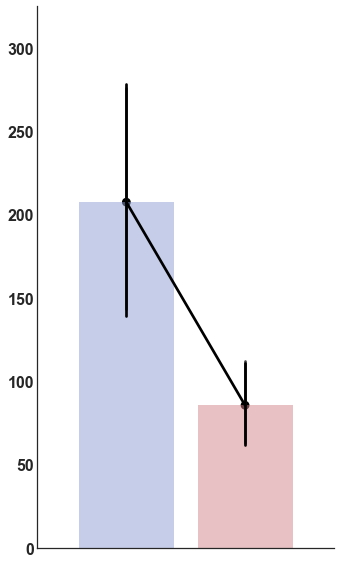

In [24]:
pd.DataFrame(columns=['Ferritin', 'Group'])
fc = pd.DataFrame(Ferr_C).drop('RJJT')
fp = pd.DataFrame(Ferr_P)
fc['group']   = 'Controls'
fp['group']   = 'Patients'
FERR =pd.concat([fc,fp])
xpal = ["#1300ff", "#87d6e9"]
#xpal =['#b5b8ff','#ffb3b9']
#xpal= ['#d0cfff', '#fecfd0']
#xpal= ['#bdc8dd', '#edb9bd']

xpal = ['#365fa5',
          #'#984ea3a
          '#cb1a1e', 
          '#368c44', 
          '#ef8148',
        ]
xpal=['#365fa5', '#cb1a1e']
xpal=['#8195e0','#dd787e']

fig, ax = plt.subplots(1)
fig.set_size_inches([5,8])
#g = sns.barplot(x="group", y="CLN_Ferritin", data=FERR,  palette=['b', 'r'])
g = sns.barplot(x="group", y="CLN_Ferritin", data=FERR,  palette=xpal, alpha=.5)
#g = sns.stripplot(x="group", y="CLN_Ferritin", data=FERR)
g = sns.pointplot(x="group", y="CLN_Ferritin", data=FERR,color='k')
plt.xlim(-0.75, 1.75)
plt.ylim(0,325)
# Finalize the plot
sns.despine(bottom=False)
#plt.setp(fig.axes, yticks=[])
plt.setp(fig.axes, xticks=[])
ax.tick_params(axis='y', labelsize=15)
plt.tight_layout(h_pad=3)
plt.xlabel('')
plt.ylabel('')
plt.yticks(fontsize=16, weight='bold')
fig.savefig(os.path.join(save_fig_dir,'FERR_comparison.png'), bbox_inches='tight', transparent = 1, dpi = 500)

# Lets look at correation between Ferritin and QSM

In [18]:

def plot_partial_correlation(data, x, y,xlim = None, ylim = None, regressors = None, color = None, annotate = 0, fig_name = None, 
                             dpi = 100, labels = True, jitter = None,fit_reg=True, scatter=1,
                             plot_marg = 1, ci = 95, lstyle='-',lw=2.5, label = None):
    
    regressors_columns = [data[regressor] for regressor in regressors]
    df_reg = pd.concat(regressors_columns, axis = 1).dropna(axis=0) 
    df = pd.concat([df_reg, data[x], data[y]], axis=1).dropna()
    
    # inititlize grid and plot regression and margins 
    grid = sns.JointGrid(x, y, data=df,xlim=xlim, ylim=ylim)#, size=size, ratio=ratio, space=space, #) 
    
    if plot_marg:
        grid.plot_marginals(sns.distplot, color = color, hist=False, kde = True, rug = 0, kde_kws={'shade':True})  
    
    grid.plot_joint(sns.regplot, fit_reg=fit_reg, scatter= scatter, color = color, x_partial = df[regressors], y_jitter = jitter, 
                    ci = ci, line_kws={'linestyle': lstyle, 'lw':lw}, scatter_kws={"s": 25})
    if labels:
        grid.set_axis_labels(x, y, fontsize= 15, weight='bold', color='blue', labelpad=10)
    else:
        grid.set_axis_labels(None,None)
    
    ## calculate regression parameters 
    
    formula = [ '%s ~ %s'%(y,x) + ' + %s'%regressor for regressor in regressors][0]
    model   = smf.ols(formula=formula, data= df)
    result = model.fit() 
    p_val  = np.round(result.pvalues[1], 7)
    pcor   = math.copysign(np.round(np.sqrt(result.rsquared), 3) , result.params[1])
    
    plt.xticks(fontsize=12, weight='bold')
    plt.yticks(fontsize=12, weight='bold')
    
    if label:
        plt.ylabel(y)
        plt.xlabel(x)
    else:
        grid.set_axis_labels()
        
    if annotate == 1:
        annotate = (plt.xlim()[1]*0.6,  plt.ylim()[1]*0.95)
        plt.annotate('R=%s, P=%s' %(pcor, p_val), xy = annotate, fontsize = 13,  color='r')
    elif annotate == 0:
        pass
    else:
        plt.annotate('R=%s, P=%s' %(pcor, p_val), xy = annotate, fontsize = 13,  color='r')
    
    
    if fig_name:
        plt.savefig(os.path.join(save_fig_dir, fig_name), dpi = dpi, bbox_inches='tight', transparent = True)
    

    print pcor, p_val
    return result

def plot_joint(df,m1,m2, drop = []):
    DF  = pd.DataFrame([df[m1] , df[m2]] ).T.dropna()
    sns.jointplot(x=m1, y=m2, data=DF.drop(drop, axis = 0), kind = 'reg')
    

0.457 0.1102208
0.465 0.4289925
0.566 0.0009138


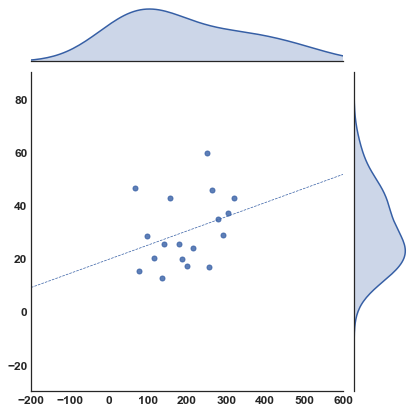

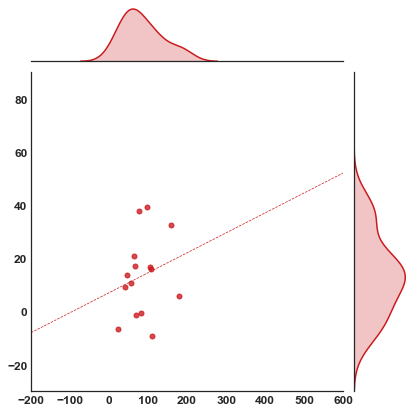

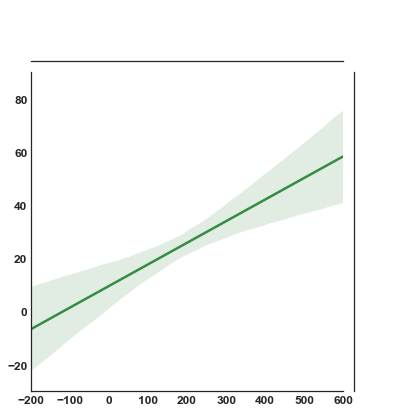

In [19]:
drop_p = ['SA5U']
drop_c = ['RJJT']
df_all = pd.concat([controls, patients], axis =0).drop(drop_p + drop_c, axis = 0)

x = 'CLN_Ferritin'
y = 'L_BG'
regressorsx = ['Gender','QI1_MAG', 'EFC_MAG']
xlim  = (-200, 600)
ylim  = (-30,90)

xpal = ["#1300ff", "#87d6e9"]
xpal=['#253bc6', '#dd2327']
xpal=['#365fa5','#cb1a1e','#368c44',]
plot_partial_correlation(controls, x, y, regressors = regressorsx, color=xpal[0],#color = '#365fa5',
                         ci = None,
                         labels = False, lstyle='--', lw=0.7, #annotate = (250,80),
                         fit_reg=1, scatter=1, plot_marg = 1, dpi = dpi, xlim=xlim,ylim=ylim, label = 0,
                         fig_name = 'corr_chi_fer_controls.png'
                        )

plot_partial_correlation(patients.drop(drop_p,axis=0), x, y, regressors = regressorsx,  color=xpal[1],# color = '#cb1a1e', 
                         ci = None,
                         labels = False, lstyle='--', lw=0.7, #annotate = (250,70),
                         fit_reg=1, scatter=1, plot_marg = 1, dpi = dpi, xlim=xlim,ylim=ylim, label = 0,
                         fig_name = 'corr_chi_ferr_patients.png'
                        )

plot_partial_correlation(df_all, x, y, regressors = regressorsx,  color=xpal[2], #color = '#368c44', 
                         labels = False,  #annotate = (250,60),
                         fit_reg=True, scatter=0, plot_marg = 0, dpi = dpi, xlim=xlim,ylim=ylim, label = 0,
                         fig_name = 'corr_chi_ferr_all.png'
                        )

# replication dataset 

In [20]:
lemon = pd.read_csv(os.path.join(pheno_dir, 'df_raw_lemon.csv'), index_col=0)
lemon_cln =pd.read_csv(os.path.join(pheno_dir, 'df_lemon_ferritin.csv'),index_col=0)
lemon_cln.index = [i.upper() for i in lemon_cln.index]
lemon['CLN_Ferritin'] = lemon_cln.Ergebnis

x = 'CLN_Ferritin'
y = 'L_BG'

lemon = lemon.drop([i for i in lemon.columns if i not in regressorsx + [x,y]], axis=1).dropna()

nstd=2
drop_ferr  = detect_outlier_subjects(lemon,'CLN_Ferritin',m=nstd)
drop_chi   = detect_outlier_subjects(lemon,y,m=2)
#drop_age   = [i for i in lemon.index if lemon.loc[i]['Age'] > 30]
drop_chibg = [i for i in lemon.index if lemon.loc[i][y] < -10.]
drop_ferrx = [i for i in lemon.index if lemon.loc[i]['CLN_Ferritin'] > 400.]

#print 'drop_age=', drop_age
#print 'drop_chi_bg', drop_chibg
#print 'drop_ferrx', drop_ferrx

drop_me =['LEMON148'] 
outliers = np.unique(drop_chi
                     +drop_ferr
                     #+drop_age
                     #+drop_chibg
                     #+drop_me
                    )
len(outliers)

LEMON156
LEMON160
LEMON162
LEMON164
LEMON166
LEMON168
LEMON174
LEMON127
LEMON146
LEMON148
LEMON156
LEMON162


10

0.462 8.5e-06


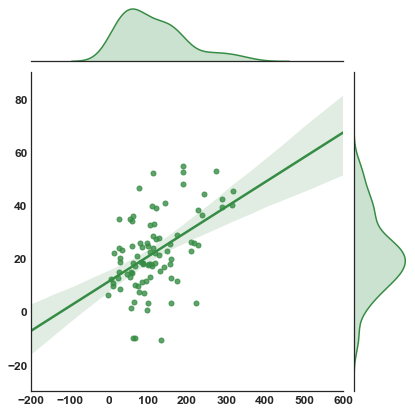

In [22]:

df = lemon.drop(outliers)

regressorsx = [ 'QI1_MAG', 'EFC_MAG']
xlim  = (-200, 600)
ylim  = (-30,90)


plot_partial_correlation(df, x, y, regressors = regressorsx, color= xpal[2],#color = '#368c44', 
                         labels = False,  annotate=False, #annotate = (200,50),
                         fit_reg=True, scatter=1, plot_marg = 1, dpi = dpi, xlim=xlim,ylim=ylim, label = 0,
                         fig_name = 'corr_chi_ferr_lemon.png'
                        )